In [1]:
# Notebook de Exploracion Inicial

# Objetivos
# - Configurar las librerias base para los algoritmos (DONE)
# - Ingestar la data del tipo de cambio LATAM (DONE)
# - Settear un ejemplo base KAN para settear entendimiento de dependencias (DONE)
# - Definir metricas base
# - Montar instancia de MLFlow

In [2]:
# Algoritmos

# 1. KAN
# 2. BITCN
# 3. SOFTS
# 4. NBEATS
# 5. NHITS

In [3]:
# Imports

import pandas as pd
import numpy as np

from neuralforecast import NeuralForecast      # Nixtla NeuralForecast
from neuralforecast.models import KAN          # KAN
from neuralforecast.models import BiTCN        # BiTCN
from neuralforecast.models import SOFTS        # SOFTS
from neuralforecast.models import NBEATS       # NBEATS
from neuralforecast.models import NHITS        # NHITS

import matplotlib.pyplot as plt

from neuralforecast.losses.pytorch import DistributionLoss
from neuralforecast.utils import AirPassengersPanel, AirPassengersStatic

In [4]:
# Acquire Data

def read_raw_data(path: str):
    df = pd.read_excel(path)
    return df

raw_df = read_raw_data('LATAM_FX.xlsx')
print(raw_df.head())
print(f'Dataframe dimensions: {raw_df.shape}')

       DATES    PEN     COP    BRL     CLP    MXN
0 1994-12-30  2.185  831.20  0.846  402.92  5.075
1 1995-01-02  2.188  831.27  0.844  402.92  4.940
2 1995-01-03  2.181  833.18  0.845  401.69  5.275
3 1995-01-04  2.182  835.38  0.845  403.81  5.575
4 1995-01-05  2.186  838.33  0.843  403.27  5.350
Dataframe dimensions: (7734, 6)


In [5]:
print(np.__version__)

1.26.4


In [6]:
# Base Example

Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]] # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

fcst = NeuralForecast(
    models=[
            KAN(h=12,
                input_size=24,
                loss = DistributionLoss(distribution="Normal"),
                max_steps=100,
                scaler_type='standard',
                futr_exog_list=['y_[lag12]'],
                hist_exog_list=None,
                stat_exog_list=['airline1'],
                ),     
    ],
    freq='M'
)

fcst.fit(df=Y_train_df, static_df=AirPassengersStatic)
forecasts = fcst.predict(futr_df=Y_test_df)

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | loss         | DistributionLoss | 5      | train
1 | padder_train | ConstantPad1d    | 0      | train
2 | scaler       | TemporalNorm     | 0      | train
3 | layers       | ModuleList       | 435 K  | train
----------------------------------------------------------
435 K     Trainable params
5         Non-trainable params
435 K     Total params
1.741     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.79it/s, v_num=2, train_loss_step=3.220, train_loss_epoch=3.270]
Validation: |                                                                                                                                              | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.21it/s, v_num=2, train_loss_step=3.220, train_loss_epoch=3.220]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.11it/s, v_num=2, train_loss_step=3.220, train_loss_epoch=3.220]


/Users/cubicles/easymoneysniper/myenv/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Users/cubicles/easymoneysniper/myenv/lib/python3.12/site-packages/utilsforecast/processing.py:438: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 125.82it/s]


/Users/cubicles/easymoneysniper/myenv/lib/python3.12/site-packages/neuralforecast/core.py:209: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


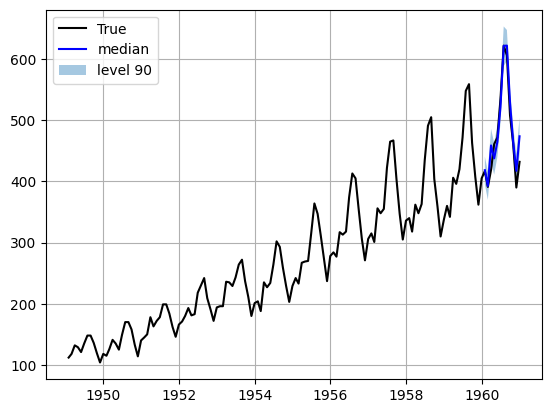

In [7]:
# Plot quantile predictions
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['KAN-median'], c='blue', label='median')
plt.fill_between(x=plot_df['ds'][-12:], 
                 y1=plot_df['KAN-lo-90'][-12:].values,
                 y2=plot_df['KAN-hi-90'][-12:].values,
                 alpha=0.4, label='level 90')
plt.legend()
plt.grid()